In [ ]:
# **1. Import & Upload**
import pandas as pd
import numpy as np
from google.colab import files
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
from datetime import timedelta
from sklearn.metrics.pairwise import cosine_similarity

# Hubungkan Google Drive
drive.mount('/content/drive')

# Unggah file CSV
uploaded = files.upload()

# Membaca file yang diunggah
file_path = list(uploaded.keys())[0]  # Dapatkan nama file pertama yang diunggah
data = pd.read_csv(file_path)
print(data.head())

# Simpan data ke format CSV di Google Drive
csv_path = '/content/drive/My Drive/Machine Learning/data.csv'
data.to_csv(csv_path, index=False)
print(f"Data telah disimpan sebagai file CSV di {csv_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving Data Historis Jakarta Stock Exchange Composite (2).csv to Data Historis Jakarta Stock Exchange Composite (2) (1).csv
      Tanggal  Terakhir Pembukaan Tertinggi  Terendah    Vol. Perubahan%
0  20/12/2024  6.983,87  6.980,17  7.032,40  6.931,58  14,57B      0,09%
1  19/12/2024  6.977,24  7.034,62  7.040,55  6.951,05  17,09B     -1,84%
2  18/12/2024  7.107,88  7.168,97  7.216,88  7.105,07  12,24B     -0,70%
3  17/12/2024  7.157,73  7.238,17  7.263,31  7.132,06  15,74B     -1,39%
4  16/12/2024  7.258,63  7.304,22  7.320,79  7.204,65  18,65B     -0,90%
Data telah disimpan sebagai file CSV di /content/drive/My Drive/Machine Learning/data.csv


In [ ]:
# **2. Training**

# Mengonversi tanggal
data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%d/%m/%Y').dt.date
data = data.sort_values('Tanggal').reset_index(drop=True)

# Menghapus koma, karakter non-numerik, dan mengonversi ke tipe data numerik (float)
columns_to_clean = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']
for col in columns_to_clean:
    data[col] = data[col].replace({',': '', 'B': '', '%': ''}, regex=True).astype(float)

# Menampilkan beberapa data setelah pembersihan
print(data.head())

# Membuat segmen 5 hari untuk data
def create_segments(data, column, window_size=5):
    segments, targets, dates = [], [], []
    for i in range(len(data) - window_size):
        segment = data[column].iloc[i:i + window_size].values
        target = data[column].iloc[i + window_size]
        segments.append(segment)
        targets.append(target)
        dates.append(data['Tanggal'].iloc[i + window_size])
    return np.array(segments), np.array(targets), dates

window_size = 5
segments, targets, target_dates = create_segments(data, 'Terakhir', window_size)

# Normalisasi data
scaler = MinMaxScaler()
segments_scaled = scaler.fit_transform(segments)
targets_scaled = scaler.fit_transform(targets.reshape(-1, 1)).flatten()

# Membentuk ulang data untuk LSTM
X = segments_scaled.reshape(segments_scaled.shape[0], segments_scaled.shape[1], 1)
y = targets_scaled

# Membagi data menjadi training dan testing
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Membuat atau memuat model pertama (LSTM)
model_path = '/content/drive/My Drive/Machine Learning/stock_prediction_model.keras'
if os.path.exists(model_path):
    model1 = load_model(model_path)
    print("Model pertama berhasil dimuat dari file.")
else:
    model1 = Sequential([
        LSTM(900, activation='relu', input_shape=(window_size, 1), return_sequences=True),
        Dropout(0.2),  # Dropout untuk mengurangi overfitting
        LSTM(900, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model1.compile(optimizer='adam', loss='mse')

# Melatih model pertama
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

history = model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1000,  # Menambah jumlah epoch
    batch_size=320,  # Mengubah ukuran batch untuk pelatihan yang lebih intens
    callbacks=[checkpoint, early_stopping]
)

# Prediksi dengan model pertama
predictions_model1 = model1.predict(X_test)

# **Model Kedua** (Optimasi berdasarkan hasil model pertama)
# Menggunakan output dari model pertama sebagai input untuk model kedua
X_optimized = predictions_model1.reshape(-1, 1)

# Membuat model kedua (misalnya regresi atau jaringan saraf tambahan)
model2 = Sequential([
    Dense(50, activation='relu', input_dim=1),
    Dropout(0.2),
    Dense(1)
])
model2.compile(optimizer='adam', loss='mse')

# Melatih model kedua dengan output dari model pertama
model2.fit(X_optimized, y_test, epochs=100, batch_size=32)

# Menyimpan model kedua
model2.save('/content/drive/My Drive/Machine Learning/stock_prediction_model2.keras')
print("Model kedua disimpan.")

      Tanggal  Terakhir  Pembukaan  Tertinggi  Terendah    Vol. Perubahan%
0  2020-12-21   6.16562    6.13162    6.19515   6.11992  23,86B      1,00%
1  2020-12-22   6.02329    6.14665    6.17446   6.01021  25,01B     -2,31%
2  2020-12-23   6.00871    6.06185    6.10435   5.85326  20,35B     -0,24%
3  2020-12-28   6.09355    6.06700    6.09501   5.97990  18,09B      1,41%
4  2020-12-29   6.03617    6.11272    6.14387   6.02670  17,51B     -0,94%
Model pertama berhasil dimuat dari file.
Epoch 1/1000
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 5.7000e-04
Epoch 1: val_loss improved from inf to 0.00095, saving model to /content/drive/My Drive/Machine Learning/stock_prediction_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - loss: 5.6007e-04 - val_loss: 9.4946e-04
Epoch 2/1000
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5.4138e-04
Epoch 2: val_loss did not improve from 0.00095
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 5.4852e-04 - val_loss: 9.5446e-04
Epoch 3/1000
3/3 ━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9067  
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7501 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6480 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5508 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4735 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4056 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3359 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2673 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2126 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1773 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1251 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1042 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0845 
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0635 
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0494 
Epoch 16/100
7/7 ━━━━━━━━━━━━━

Model berhasil dimuat untuk prediksi.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Kemiripan Cosine: 99.98272%
Prediksi Harga untuk Hari Berikutnya: 6.96562
Harga Terakhir: 6.97724
Perubahan Persentase Prediksi: -0.16653%
Tanggal Prediksi Berikutnya: 2024-12-23
Keputusan: Anda tidak perlu membeli pada hari prediksi.
Prediksi Harga Jual: 6.97
Hasil prediksi disimpan di /content/drive/My Drive/Machine Learning/stock_predictions.csv
Plot disimpan di /content/drive/My Drive/Machine Learning/actual_vs_predicted_plot.png


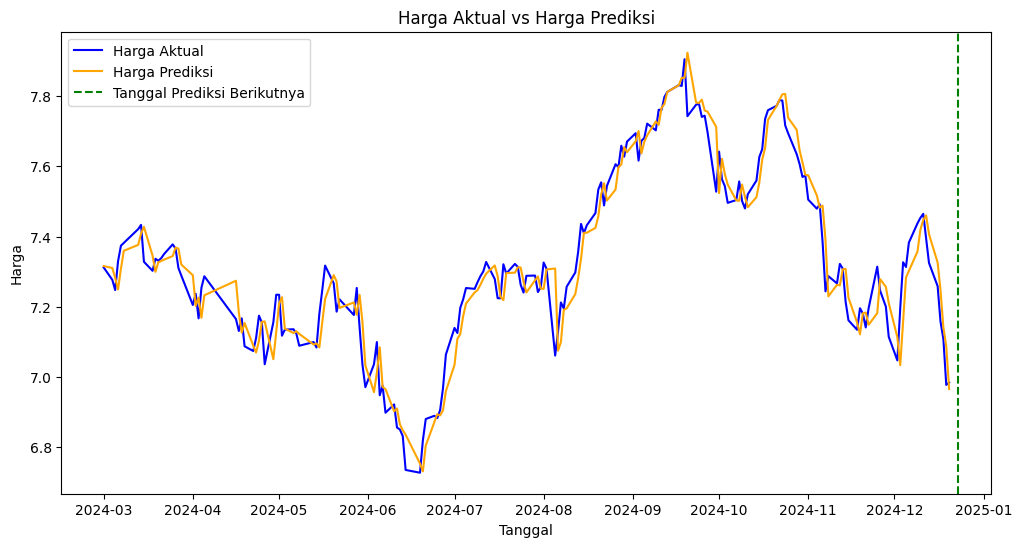

In [ ]:
# **3. Proses**
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Memuat model yang sudah dilatih
model2 = load_model(model_path)
print("Model berhasil dimuat untuk prediksi.")

# Prediksi dan membalik normalisasi
y_pred_scaled = model2.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Menghitung kemiripan cosine untuk segmen terakhir
last_segment = X_test[-1].reshape(1, -1)  # Flatten untuk perhitungan kemiripan
X_test_flat = X_test.reshape(X_test.shape[0], -1)
cosine_sim = cosine_similarity(last_segment, X_test_flat)[0]
most_similar_idx = np.argmax(cosine_sim[:-1])  # Kecualikan segmen terakhir
similarity_percentage = cosine_sim[most_similar_idx] * 100

# Menghitung prediksi dan perubahan persentase
last_price = scaler.inverse_transform(X_test[-1].reshape(-1, X_test.shape[-1])).flatten()[-1]
predicted_price = y_pred[-1][0]
percent_change = ((predicted_price - last_price) / last_price) * 100

# Fungsi untuk mendapatkan tanggal berikutnya yang merupakan hari kerja (Senin - Jumat)
def get_next_trading_day(last_date):
    # Tambahkan satu hari
    next_day = last_date + timedelta(days=1)
    # Jika hari Sabtu atau Minggu, tambahkan hari hingga hari Senin
    while next_day.weekday() >= 5:  # 5 = Sabtu, 6 = Minggu
        next_day += timedelta(days=1)
    return next_day

# Dapatkan tanggal terakhir yang digunakan dalam data untuk prediksi
last_date = target_dates[-1]
# Dapatkan tanggal pasar saham berikutnya
next_trading_day = get_next_trading_day(last_date)

# **Model Decision Tree untuk Membeli atau Tidak**
# Menentukan fitur apakah harga prediksi lebih tinggi dari harga terakhir (indikasikan beli atau tidak)
features_buy = np.array([[last_price, predicted_price]])
labels_buy = [1 if predicted_price > last_price else 0]  # 1: beli, 0: tidak beli

# Melatih model decision tree untuk keputusan beli atau tidak
buy_model = DecisionTreeClassifier()
buy_model.fit(features_buy, labels_buy)

# Membuat keputusan untuk membeli atau tidak berdasarkan harga prediksi
buy_decision = buy_model.predict(features_buy)[0]

# **Model Decision Tree untuk Prediksi Harga Jual**
# Fitur yang digunakan adalah harga terakhir dan harga prediksi
features_sell = np.array([[last_price, predicted_price]])
sell_model = DecisionTreeRegressor()
sell_model.fit(features_sell, [predicted_price])

# Prediksi harga jual
predicted_sell_price = sell_model.predict(features_sell)[0]

# Output hasil
print(f"Kemiripan Cosine: {similarity_percentage:.5f}%")
print(f"Prediksi Harga untuk Hari Berikutnya: {predicted_price:.5f}")
print(f"Harga Terakhir: {last_price:.5f}")
print(f"Perubahan Persentase Prediksi: {percent_change:.5f}%")
print(f"Tanggal Prediksi Berikutnya: {next_trading_day}")

# Keputusan untuk membeli atau tidak
if buy_decision == 1:
    print("Keputusan: Anda harus membeli pada hari prediksi.")
else:
    print("Keputusan: Anda tidak perlu membeli pada hari prediksi.")

# Prediksi harga jual
print(f"Prediksi Harga Jual: {predicted_sell_price:.2f}")

# Simpan hasil prediksi ke file CSV dengan tanggal prediksi
predictions_df = pd.DataFrame({
    'Tanggal': target_dates[train_size:],
    'Harga Aktual': y_actual.flatten(),
    'Harga Prediksi': y_pred.flatten(),
    'Perubahan Persentase': ((y_pred.flatten() - y_actual.flatten()) / y_actual.flatten()) * 100,
    'Tanggal Prediksi': [get_next_trading_day(date) for date in target_dates[train_size:]],
    'Keputusan Beli': ['Beli' if buy_decision == 1 else 'Tidak Beli'] * len(target_dates[train_size:]),
    'Prediksi Harga Jual': [predicted_sell_price] * len(target_dates[train_size:])
})

predictions_csv_path = '/content/drive/My Drive/Machine Learning/stock_predictions.csv'
predictions_df.to_csv(predictions_csv_path, index=False)
print(f"Hasil prediksi disimpan di {predictions_csv_path}")

# Plot aktual vs prediksi dengan tanggal prediksi
plt.figure(figsize=(12, 6))
plt.plot(target_dates[train_size:], y_actual, label='Harga Aktual', color='blue')
plt.plot(target_dates[train_size:], y_pred, label='Harga Prediksi', color='orange')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.title('Harga Aktual vs Harga Prediksi')

# Menambahkan garis vertikal untuk menunjukkan tanggal prediksi berikutnya
plt.axvline(x=next_trading_day, color='green', linestyle='--', label='Tanggal Prediksi Berikutnya')

plt.legend()
plt.savefig('/content/drive/My Drive/Machine Learning/actual_vs_predicted_plot.png')
print("Plot disimpan di /content/drive/My Drive/Machine Learning/actual_vs_predicted_plot.png")
plt.show()
